# Histogrammar

In [1]:
%pylab inline
import histogrammar as hg
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## Some Datasets form which we create Histograms

generally will be ROOT files / panda dataframes, etc... we have multiple files for each MC sample and data

In [2]:
background_sample = np.random.normal(loc = 0.0, scale=1.0, size = 30)
signal_sample     = np.random.normal(loc = 0.5, scale=1.0, size = 15)
data_sample       = np.random.normal(loc = 0.1, scale=1.0, size = 45)

## Creating Histograms with hg

In [3]:
signal_histogram     = hg.Bin(3,-1.5,1.5,lambda d: d,hg.Count())
background_histogram = hg.Bin(3,-1.5,1.5,lambda d: d,hg.Count())
data_histogram       = hg.Bin(3,-1.5,1.5,lambda d: d,hg.Count())

In [4]:
for d in background_sample:
    background_histogram.fill(d)
    
for d in signal_sample:
    signal_histogram.fill(d)
    
for d in data_sample:
    data_histogram.fill(d)

In [5]:
print(background_histogram.toJson()['data']['values'])
print(signal_histogram.toJson()['data']['values'])
print(data_histogram.toJson()['data']['values'])

[9.0, 11.0, 8.0]
[1.0, 6.0, 5.0]
[15.0, 15.0, 7.0]


## Creating a Statistical model based on the Histograms (HistFactory)

In [6]:
import pyhf

in this simple model, we just take the histograms for each sample. For the background normalization we assign a 10% normalization uncertainty

In [7]:
spec = {
    'singlechannel': {
        'signal': {'data': signal_histogram.toJson()['data']['values'],
            'mods': [
                {'name': 'mu','type': 'normfactor','data': None}
            ]
        },
        'background': {
            'data': background_histogram.toJson()['data']['values'],
            'mods': [
                {'name': 'bkg_norm','type': 'normsys','data': {'lo': 0.90, 'hi': 1.10}}
            ]
        }
    }
}

In [8]:
p = pyhf.Model(spec)

data = data_histogram.toJson()['data']['values'] + p.config.auxdata

## Interval Estimation / Limit Setting

let's set a limit on the signal strength µ

In [9]:
def invert_interval(testmus,cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = [x for x in cls_exp_sigma]
        point05cross['exp'].append(np.interp(test_size,list(reversed(yvals)),list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,list(reversed(yvals)),list(reversed(testmus)))
    return point05cross

def plot_results(testmus,cls_obs, cls_exp, test_size = 0.05):
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests,cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)

/Users/jovyan/pyhf/src/pyhf/__init__.py:399: RuntimeWarning: divide by zero encountered in double_scalars
  CLs = CLb / CLsb


{'exp': [0.49635286138206663,
  0.6820216889491351,
  0.9744444893430112,
  1.4144324596835618,
  1.996560529135182],
 'obs': 1.2330688941880004}

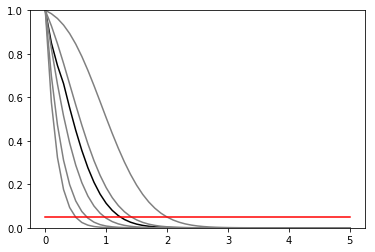

In [10]:
mutests = np.linspace(0,5,51)
tests = [runOnePoint(muTest, data, p, p.config.suggested_init(), p.config.suggested_bounds())[-2:] 
         for muTest in mutests]
cls_obs = [test[0] for test in tests]
cls_exp = [[test[1][i] for test in tests] for i in range(5)]

plot_results(mutests, cls_obs, cls_exp)
invert_interval(mutests, cls_obs, cls_exp)